# 1. Data Loading And Spike Extraction

In [4]:
import sys
import os
import math

import numpy as np
import matplotlib.pyplot as plt

# Get the absolute path of the parent directory (project root)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the project root to the Python path
if project_root not in sys.path:
    sys.path.append(project_root)

from src.data_processor import download_and_extract_data, load_openephys_data, apply_bandpass_filter, apply_notch_filters
from src.spike_detector import dynamic_spike_capture_from_signal, save_snippets
from src.utils import plot_power_spectrum, perform_pca_and_plot



In [5]:
# 1. Download Data 
# You only need to run this part once to download the data
data_dir_path = download_and_extract_data(url="https://uni-bonn.sciebo.de/s/x2mNZ3pm3hAHKQa/download")


Download and extraction complete.


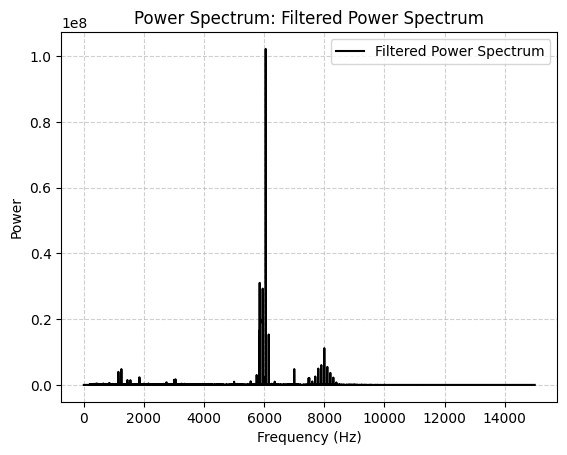

In [6]:
#Filter Data
channel_idx = 40
rec = load_openephys_data(data_dir=data_dir_path)
fs = rec.get_sampling_frequency()
traces = rec.get_traces()[:, channel_idx]

# Apply filters using the new combined functions
bandpassed_trace = apply_bandpass_filter(traces, fs, lowcut=300, highcut=8000)

# Define a list of notch frequencies
notch_frequencies = [50, 150, 200, 250, 300, 350, 400, 500, 550]
filtered_trace = apply_notch_filters(bandpassed_trace, fs, notch_frequencies)

# Visualize the effect of filtering
plot_power_spectrum(filtered_trace, fs, 'Filtered Power Spectrum', 'black')

In [7]:
# 2. Capture Spikes
captured_snippets = []
for spike_snippet, _ in dynamic_spike_capture_from_signal(filtered_trace, fs, start_threshold_std=3):
    captured_snippets.append(spike_snippet)
    
captured_snippets_array = np.stack(captured_snippets, axis=0)
print(f"Total spikes captured: {len(captured_snippets_array)}")

Total spikes captured: 10924


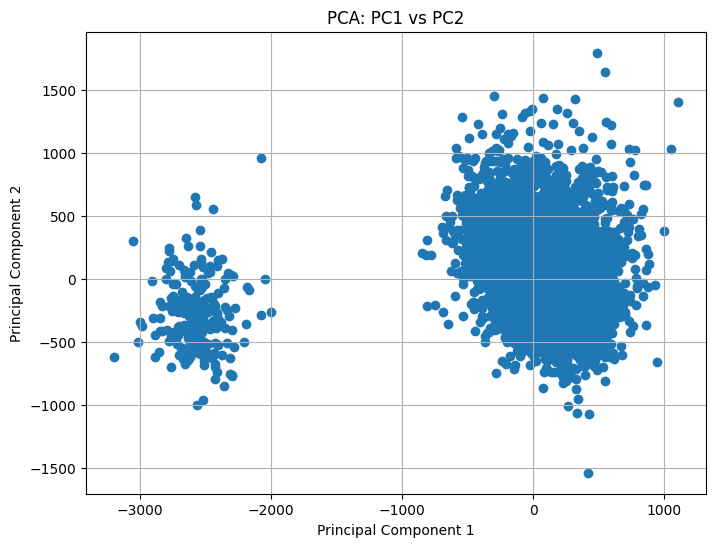

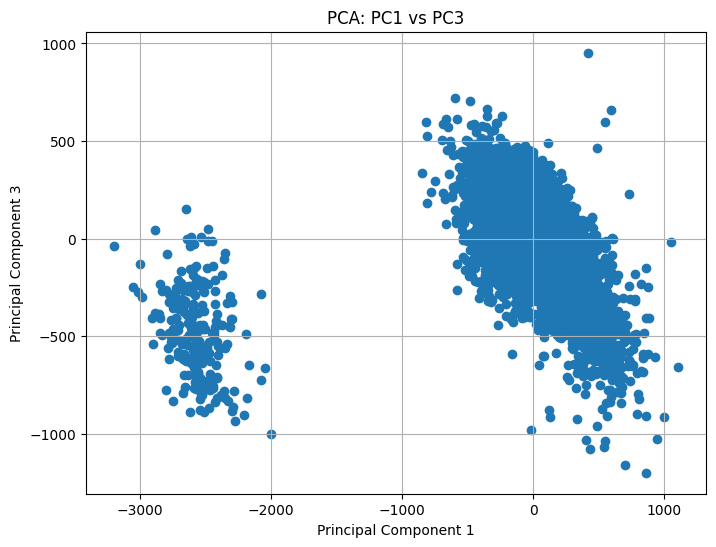

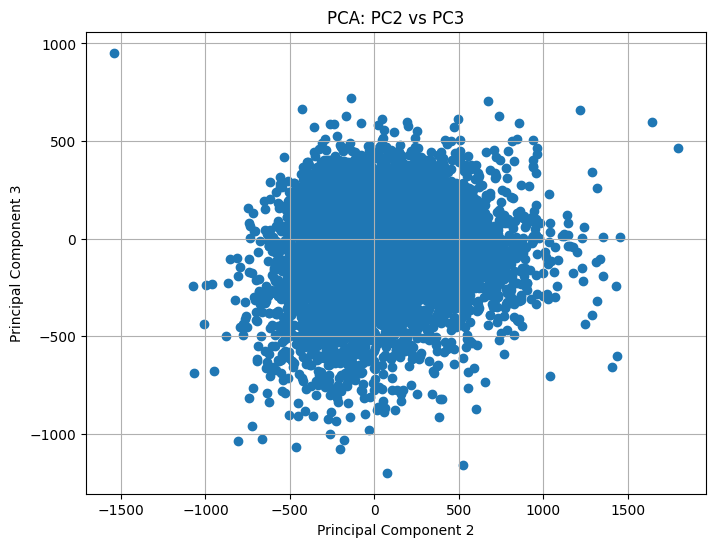

In [8]:
# 3. Analyze and Save Snippets
# Perform PCA
pca_transformed_data = perform_pca_and_plot(captured_snippets_array)


Creating a 2D scatterplot...


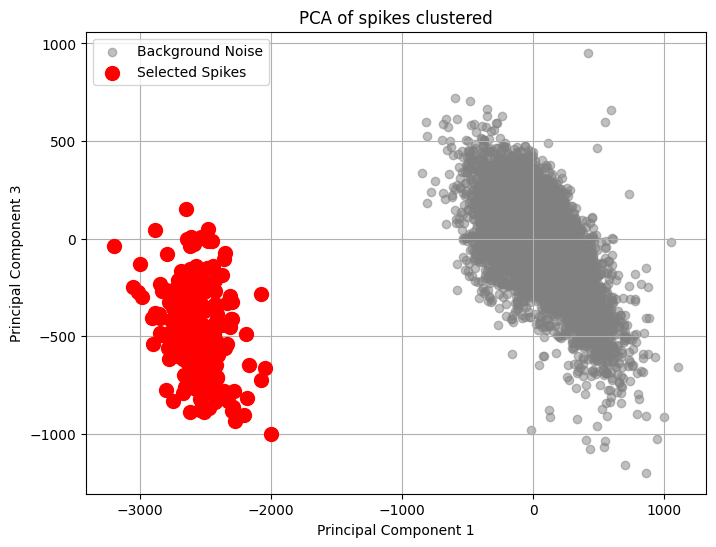

In [9]:
# Manual selection of a cluster in PCA space for saving (this part is exploratory)
# The code you provided for manual selection in the original prompt is a good example for a notebook.
# For example:
#plt.scatter(pca_transformed_data[:, 0], pca_transformed_data[:, 2])
#Then draw a circle or box to define a mask.

print("\nCreating a 2D scatterplot...")
plt.figure(figsize=(8, 6))

# --- PROGRAMMATIC SELECTION ---
# Define the circle's center and radius using variables
# You can change these values to select a different area
circle_center = (-2500, -500)
circle_radius = 1000


pca_snippet_channels = pca_transformed_data[:,[0,2]]

# Create a list to store the indices of the selected points
selected_indices = []

# Find all points within the defined circle
for idx, (x, y) in enumerate(pca_snippet_channels):
    distance = math.sqrt((x - circle_center[0])**2 + (y - circle_center[1])**2)
    if distance <= circle_radius:
        selected_indices.append(idx)

# Create a boolean mask to separate selected and non-selected data
selected_mask = np.zeros(len(pca_snippet_channels), dtype=bool)
selected_mask[selected_indices] = True
selected_spikes = pca_transformed_data[selected_mask]
background_noise = pca_transformed_data[~selected_mask]

# Plot the background_noise points first
plt.scatter(background_noise[:, 0], background_noise[:, 2], c='gray', alpha=0.5, label='Background Noise')

# Plot the selected_spikes
plt.scatter(selected_spikes[:, 0], selected_spikes[:, 2], color='red', s=100, label='Selected Spikes', zorder=10)

plt.title(f'PCA of spikes clustered')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 3')
plt.grid(True)

# Draw the circle on the plot
#circle = plt.Circle(circle_center, circle_radius, color='red', fill=False, linestyle='--', linewidth=2)
#plt.gca().add_patch(circle)

plt.legend()

plt.show()


In [11]:
# Save the classified data using the new function
save_snippets(selected_spikes, 'data/spikes', f'channel_spikes_{channel_idx}.npy')
save_snippets(background_noise, 'data/spikes', f'channel_background_{channel_idx}.npy')

Saved 229 snippets to data\spikes\channel_spikes_40.npy
Saved 10695 snippets to data\spikes\channel_background_40.npy
